In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.metrics import plot_precision_recall_curve, make_scorer, precision_score, average_precision_score
from sklearn.metrics import precision_recall_curve, auc

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import ComplementNB

In [2]:
df = pd.read_csv(r'C:\Users\2bogu\Desktop\Sringboard_Materials\capstone2\data\interim\new_new')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5163 entries, 0 to 5162
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ORIGINAL LOAN AMOUNT    5163 non-null   float64
 1   ORIGINAL TERM           5163 non-null   int64  
 2   INTEREST RATE           5163 non-null   float64
 3   DEBT TO INCOME          5163 non-null   float64
 4   PAYMENT AMOUNT          5163 non-null   float64
 5   bad                     5163 non-null   int64  
 6   co-signed               5163 non-null   int64  
 7   avg_credit_score        5163 non-null   float64
 8   has_successor_num       5163 non-null   int64  
 9   unpledged               5163 non-null   int64  
 10  underwritten_t1         5163 non-null   int64  
 11  loan_type_smart_energy  5163 non-null   int64  
 12  purpose_ee              5163 non-null   int64  
 13  purpose_sol             5163 non-null   int64  
dtypes: float64(5), int64(9)
memory usage: 56

In [4]:
y = df[['bad']]
X = df.drop('bad', axis=1)

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100, stratify=y)

In [6]:
y = y_test.append(y_train)

In [8]:
len(y)

5163

In [5]:
X_train.head()

,const,ORIGINAL LOAN AMOUNT,ORIGINAL TERM,INTEREST RATE,DEBT TO INCOME,PAYMENT AMOUNT,co-signed,avg_credit_score,has_successor_num,unpledged,underwritten_t1,loan_type_smart_energy,purpose_ee,purpose_sol
728,1.0,12713.0,60,3.49,0.28,231.0,1,760.0,0,0,1,1,1,0
3082,1.0,11020.0,180,3.49,0.87,79.0,0,704.0,0,1,0,1,1,0
3956,1.0,17225.0,180,3.49,0.49,123.0,0,760.0,0,0,1,0,1,0
2318,1.0,16120.0,180,3.49,0.36,115.0,1,751.5,0,0,1,1,1,0
4338,1.0,17175.0,180,3.49,0.48,123.0,1,727.0,0,0,1,0,0,1


In [6]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()

X_train[['ORIGINAL LOAN AMOUNT', 'ORIGINAL TERM', 
         'INTEREST RATE','DEBT TO INCOME', 
         'PAYMENT AMOUNT', 'avg_credit_score']] = X_scaler.fit_transform(X_train[['ORIGINAL LOAN AMOUNT', 'ORIGINAL TERM', 
                                                                                  'INTEREST RATE', 'DEBT TO INCOME', 
                                                                                  'PAYMENT AMOUNT', 'avg_credit_score']])

X_test[['ORIGINAL LOAN AMOUNT', 'ORIGINAL TERM', 
        'INTEREST RATE', 'DEBT TO INCOME', 
        'PAYMENT AMOUNT', 'avg_credit_score']] = X_scaler.transform(X_test[['ORIGINAL LOAN AMOUNT', 'ORIGINAL TERM', 
                                                                            'INTEREST RATE', 'DEBT TO INCOME', 
                                                                            'PAYMENT AMOUNT', 'avg_credit_score']])


C:\Users\2bogu\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\2bogu\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\2bogu\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [11]:
cv = StratifiedKFold(n_splits=5)
xcv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=2)

In [26]:
def classify(model, X_train=X_train, y_train=y_train, X_test=X_test ):
    '''Takes in model, X_train, X_test, y_train
    returns tuple of (fit model, y_pred, predict_proba[:,1])'''
    
    m = model.fit(X_train, y_train)
    
    pred = m.predict(X_test)
    
    prob = m.predict_proba(X_test)[:,1]
    
    return (m, pred, prob)

### CUSTOME SCORERS FOR PRECISION METRICS
pre_scorer = make_scorer(precision_score)
#### AVERAGE PRECISION SCORE
avg_pre_scorer = make_scorer(average_precision_score)
#### AUC FOR PRECISION RECALL CURVE
def pr_auc(y_true, y_score, **kwargs):
    pre, re, _ = precision_recall_curve(y_true, y_score)
    return auc(re, pre)

pr_auc_scorer = make_scorer(pr_auc)

### CV FUNCTION THAT RETURNS THREE PRECISION SCORES
def p3_cv(model, X=X_train, y=y_train, cv=xcv, stats=False):
    '''takes the model, X_train, y_train, cv(=5)
    returns auc of precision recall curve, precision, and average precision'''
    
    scores = cross_val_score(model, X, y, cv=cv, 
                             scoring=pre_scorer, n_jobs=-1)
    
    
    scores1 = cross_val_score(model, X, y, cv=cv, 
                             scoring=avg_pre_scorer, n_jobs=-1)
    
    scores2 = cross_val_score(model, X, y, cv=cv, 
                             scoring=pr_auc_scorer, n_jobs=-1)
    
    if stats:
        print(str(model))
        print(scores)
        print('Mean precision:', scores.mean())
        print('STD precision:', scores.std())
        print(scores1)
        print('Mean average precision:', scores1.mean())
        print('STD average precision:', scores1.std())
        print(scores2)
        print('Mean PR auc:', scores2.mean())
        print('STD PR auc:', scores2.std())
    
    return (scores.mean(), scores1.mean(), scores2.mean())


def model_cv(model, X=X_train, y=y_train, cv=5, scoring=pre_scorer, f1=True, stats=False):
    '''takes the model, X_train, y_train, cv(=5), scoring(='roc_auc')
    returns mean roc_auc and mean of input socre default f1, prints array, mean, std of scores scores'''
    
    scores = cross_val_score(model, X, y, cv=cv, 
                             scoring='pr_auc', n_jobs=-1)
    
    
    scores1 = cross_val_score(model, X, y, cv=cv, 
                             scoring=scoring, n_jobs=-1)
    
    if stats:
        print(str(model))
        print(scores)
        print('Mean roc-auc:', scores.mean())
        print('STD roc-auc', scores.std())
    
    return (scores.mean(), scores1.mean())

def model_cv1(model, X=X_train, y=y_train, cv=5, scoring=pre_scorer):
    '''takes the model, X_train, y_train, cv(=5), scoring(='roc_auc')
    returns mean roc_auc and mean of input socre default f1, prints array, mean, std of scores scores'''
    
    
    scores = cross_val_score(model, X, y, cv=cv, 
                             scoring=scoring, n_jobs=-1)    
    
    return scores.mean()


In [8]:
###### COME BACK TO THIS
###### ALTER FOR PRECISION RECALL CURVE
def find_threshold(probs, y_test=y_test):
    '''takes predict_proba[:,1] for certain model, y_test is set because imonly doing this for the one y_test
    uses Youdens J statistic
    prints the threshold
    returns new predictions given the threshold'''
    
    fpr, tpr, thresholds = precision_recall_curve(y_test, probs)
    
    gmeans = tpr - fpr
    
    thresh = thresholds[np.argmax(gmeans)]
    
    print('The threshold is', thresh)
    return (probs >= thresh).astype(int)


In [9]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values.ravel()
y_test= y_test.values.ravel()

In [10]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE, ADASYN, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler

smo = SMOTE(sampling_strategy=0.1) # 'over' in pipeline
bor = BorderlineSMOTE(sampling_strategy=0.1) # 'over' in pipeline
ada = ADASYN(sampling_strategy=0.1) # 'over'
svm = SVMSMOTE(sampling_strategy=0.1)

under = RandomUnderSampler(sampling_strategy=0.5)

In [11]:
classifiers = ['Log Reg',
               'KNN', 
               'Random Forest', 
               'Gradient Boost',
              ] # 'ComplementNB'

### ACTUALLY AVERAGE PERCISION SCORE
scores_roc = []
smo_scores_roc = []
bor_scores_roc = []
ada_scores_roc = []
svm_scores_roc = []


scores_f1 = []
smo_scores_f1 = []
bor_scores_f1 = []
ada_scores_f1 = []
svm_scores_f1 = []

lr = LogisticRegression(random_state=2)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=2)
gb = GradientBoostingClassifier(random_state=2)


models = [lr, knn, rf, gb]

for m in models:
    steps= [('model', m)]
    pl = Pipeline(steps=steps)
    roc, f1 = model_cv(pl, cv=xcv)
    scores_roc.append(round(roc,3))
    scores_f1.append(round(f1,3))
    
for m in models:
    steps= [('over', smo), ('under', under), ('model', m)]
    pl = Pipeline(steps=steps)
    roc, f1 = model_cv(pl, cv=xcv)
    smo_scores_roc.append(round(roc,3))
    smo_scores_f1.append(round(f1,3))
    
for m in models:
    steps= [('over', bor), ('under', under), ('model', m)]
    pl = Pipeline(steps=steps)
    roc, f1 = model_cv(pl, cv=xcv)
    bor_scores_roc.append(round(roc,3))
    bor_scores_f1.append(round(f1,3))
    
for m in models:
    steps= [('over', ada), ('under', under), ('model', m)]
    pl = Pipeline(steps=steps)
    roc, f1 = model_cv(pl, cv=xcv)
    ada_scores_roc.append(round(roc,3))
    ada_scores_f1.append(round(f1,3))
    
for m in models:
    steps= [('over', svm), ('under', under), ('model', m)]
    pl = Pipeline(steps=steps)
    roc, f1 = model_cv(pl, cv=xcv)
    svm_scores_roc.append(round(roc,3))
    svm_scores_f1.append(round(f1,3))
    
roc_auc_cv = pd.DataFrame(list(zip(scores_roc, 
                                   smo_scores_roc,
                                   bor_scores_roc,
                                   ada_scores_roc,
                                   svm_scores_roc)),
                          index=classifiers,
                         columns=['ROC-AUC', 'SMOTE ROC-AUC',
                                 'Borderline ROC_AUC', 'ADASYN ROC-AUC', 'SVM SMOTE ROC-AUC'])

f1_cv = pd.DataFrame(list(zip(scores_f1, 
                              smo_scores_f1,
                              bor_scores_f1,
                              ada_scores_f1,
                              svm_scores_f1)),
                          index=classifiers,
                         columns=['Precision', 'SMOTE Precision',
                                 'Borderline Precision', 'ADASYN Precision', 'SVM SMOTE Precision'])

In [12]:
roc_auc_cv

,ROC-AUC,SMOTE ROC-AUC,Borderline ROC_AUC,ADASYN ROC-AUC,SVM SMOTE ROC-AUC
Log Reg,0.855,0.854,0.852,0.852,0.854
KNN,0.718,0.814,0.810,0.802,0.802
Random Forest,0.841,0.852,0.853,0.854,0.847
Gradient Boost,0.861,0.862,0.860,0.863,0.857


In [13]:
f1_cv # CURRENTLY F BETA

,Precision,SMOTE Precision,Borderline Precision,ADASYN Precision,SVM SMOTE Precision
Log Reg,0.526,0.202,0.203,0.198,0.223
KNN,0.323,0.163,0.169,0.163,0.182
Random Forest,0.590,0.234,0.232,0.229,0.234
Gradient Boost,0.467,0.209,0.217,0.200,0.221


<AxesSubplot:>

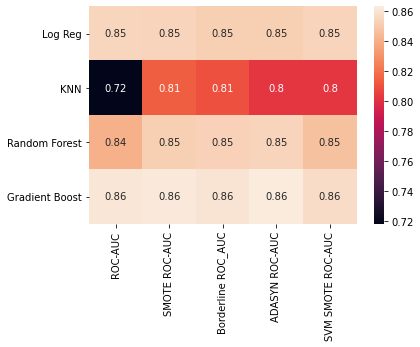

In [14]:
import seaborn as sns

sns.heatmap(roc_auc_cv, annot=True)

<AxesSubplot:>

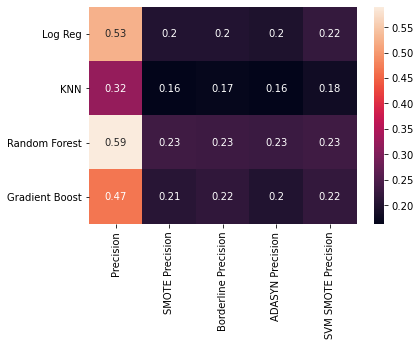

In [15]:
sns.heatmap(f1_cv, annot=True)

In [29]:
classifiers = ['Log Reg',
               'KNN', 
               'Random Forest', 
               'Gradient Boost',
              ] # 'ComplementNB'

### AREA UNDER PRECISION RECALL CURVE
scores_auc = []

### PRECISION W DEFAULT THRESHOLD
scores_p = []

### AVERAGE PRECISION
scores_avgp = []

lr = LogisticRegression(random_state=2)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=2)
gb = GradientBoostingClassifier(random_state=2)


models = [lr, knn, rf, gb]

for m in models:
    steps= [('model', m)]
    pl = Pipeline(steps=steps)
    p, avg_p, pr_auc = p3_cv(pl, cv=xcv)
    scores_p.append(round(p,3))
    scores_avgp.append(round(avg_p,3))
    scores_auc.append(round(pr_auc,3))
    

precision_scores = pd.DataFrame(list(zip(scores_p, scores_avgp, scores_auc)),
                          index=classifiers,
                         columns=['Precision','Avg Precision','P/R AUC'])


<AxesSubplot:>

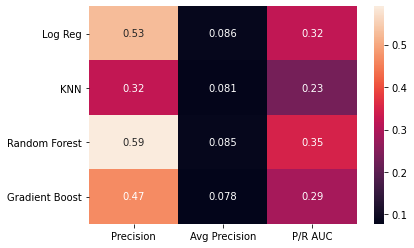

In [30]:
import seaborn as sns

sns.heatmap(precision_scores, annot=True)

# Hyperparameter Tuning

In [34]:
def gs_tuning(model, params, X=X_train, y=y_train, scoring=pre_scorer, n_jobs=-1, cv=cv):
    
    gs = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=scoring,
                    n_jobs=n_jobs,
                    cv=cv,
                    refit=True)
    
    m = gs.fit(X, y)
    #pred = m.predict_proba(X_test)[:,1]
    
    print(m.best_params_,)
    print('Train score:', m.best_score_)
    print('Test score:', m.score(X_test, y_test))#roc_auc_score(y_test, pred)
    print(m.best_estimator_)
    
    return m.best_estimator_

### LOGISTIC REGRESSION

In [46]:
lr_ = LogisticRegression(random_state=2, n_jobs=-1)

params = {'penalty':['l1', 'l2', 'elasticnet', 'none'], 
          'C':[0.01,0.1,1,10], 
          'class_weight':['balanced', None], 
          'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'l1_ratio':[.1, .3, .5, .7, .9]} 
          

lr_pre = gs_tuning(lr_, params)

{'C': 0.1, 'class_weight': None, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Train score: 0.7316666666666667
Test score: 0.5
LogisticRegression(C=0.1, l1_ratio=0.1, n_jobs=-1, penalty='l1', random_state=2,
                   solver='saga')


C:\Users\2bogu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
C:\Users\2bogu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [43]:
lr_ = LogisticRegression(random_state=2, n_jobs=-1)

params = {'penalty':['l1', 'l2', 'elasticnet', 'none'], 
          'C':[0.01,0.1,1,10], 
          'class_weight':['balanced', None], 
          'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'l1_ratio':[.1, .3, .5, .7, .9]} 
          

lr_avg_pre = gs_tuning(lr_, params, scoring=avg_pre_scorer)

C:\Users\2bogu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
C:\Users\2bogu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 10, 'class_weight': 'balanced', 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'sag'}
Train score: 0.12819007454587306
Test score: 0.15361618456366055
LogisticRegression(C=10, class_weight='balanced', l1_ratio=0.1, n_jobs=-1,
                   random_state=2, solver='sag')


In [44]:
lr_ = LogisticRegression(random_state=2, n_jobs=-1)

params = {'penalty':['l1', 'l2', 'elasticnet', 'none'], 
          'C':[0.01,0.1,1,10], 
          'class_weight':['balanced', None], 
          'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'l1_ratio':[.1, .3, .5, .7, .9]} 
          

lr_pr_auc = gs_tuning(lr_, params, scoring=pr_auc_scorer)

{'C': 0.01, 'class_weight': None, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Train score: 0.5251807951987997
Test score: 0.02517428350116189
LogisticRegression(C=0.01, l1_ratio=0.1, n_jobs=-1, penalty='l1',
                   random_state=2, solver='liblinear')


C:\Users\2bogu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
C:\Users\2bogu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [51]:
lr_pre_pred = lr_pre.predict(X_test)
lr_pre_proba = lr_pre.predict_proba(X_test)[:,1]

lr_avg_pre_pred = lr_avg_pre.predict(X_test)
lr_avg_pre_proba = lr_avg_pre.predict_proba(X_test)[:,1]

lr_pr_auc_pred = lr_pr_auc.predict(X_test)
lr_pr_auc_proba = lr_pr_auc.predict_proba(X_test)[:,1]

In [57]:
lr_pre_proba


array([0.01297676, 0.13331579, 0.02398572, ..., 0.15140317, 0.01889406,
       0.03967114])

Text(0.5, 1.0, 'Logestic Regression, precision/recall auc tuned')

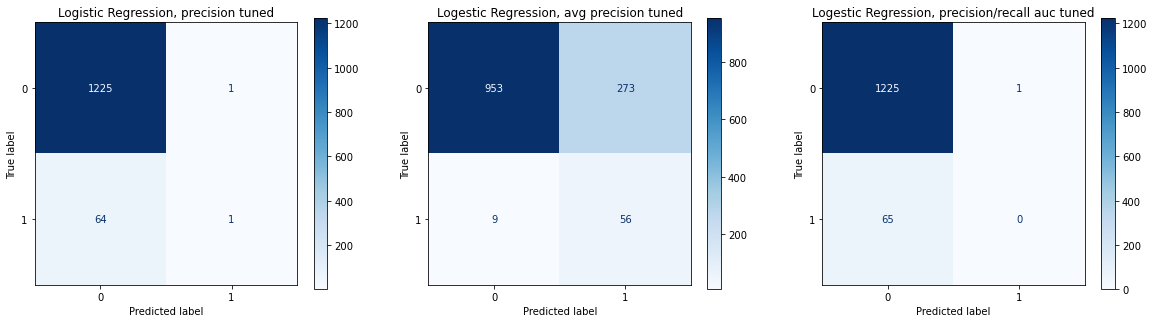

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

### FOR NORMALIZED MATRIXES
#cm1 = confusion_matrix(y_test, lr_pre_pred, normalize='true')
#cm2 = confusion_matrix(y_test, lr_avg_pre_pred, normalize='true')
#cm3 = confusion_matrix(y_test, lr_pr_auc_pred, normalize='true')

cm1 = confusion_matrix(y_test, lr_pre_pred)
cm2 = confusion_matrix(y_test, lr_avg_pre_pred)
cm3 = confusion_matrix(y_test, lr_pr_auc_pred)

cm1_dis = ConfusionMatrixDisplay(cm1).plot(ax=ax1, cmap=plt.cm.Blues)
cm2_dis = ConfusionMatrixDisplay(cm2).plot(ax=ax2, cmap=plt.cm.Blues)
cm3_dis = ConfusionMatrixDisplay(cm3).plot(ax=ax3, cmap=plt.cm.Blues)

ax1.set_title('Logistic Regression, precision tuned')
ax2.set_title('Logestic Regression, avg precision tuned')
ax3.set_title('Logestic Regression, precision/recall auc tuned')

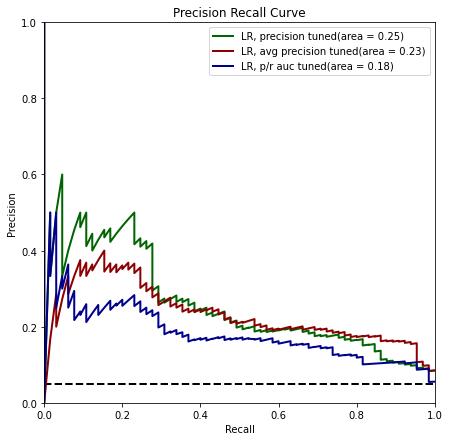

In [67]:
fig = plt.figure(figsize=(7,7))
lw = 2
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill,no_skill], color='black', lw=lw, linestyle='--')

precision, recall, _ = precision_recall_curve(y_test, lr_pre_proba)
auc_ = auc(recall, precision)
plt.plot(recall, precision, color='darkgreen', lw=lw, label='LR, precision tuned(area = %0.2f)' % auc_)

precision, recall, _ = precision_recall_curve(y_test, lr_avg_pre_proba)
auc_ = auc(recall, precision)
plt.plot(recall, precision, color='darkred', lw=lw, label='LR, avg precision tuned(area = %0.2f)' % auc_)

precision, recall, _ = precision_recall_curve(y_test, lr_pr_auc_proba)
auc_ = auc(recall, precision)
plt.plot(recall, precision, color='darkblue', lw=lw, label='LR, p/r auc tuned(area = %0.2f)' % auc_)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc="upper right")
plt.show()

### RANDOM FOREST

In [45]:
def gs_rand(model, params, X=X_train, y=y_train, scoring=pre_scorer, n_jobs=-1, cv=cv):
    
    gs = RandomizedSearchCV(model,
                           params,
                           scoring=scoring,
                           n_jobs=n_jobs,
                           cv=cv,
                           n_iter=50,
                           refit=True)
    
    m = gs.fit(X_train,y_train)
    
    #pred = m.predict_proba(X_test)[:,1]
    
    print(m.best_params_,)
    print('Train score:', m.best_score_)
    print('Test score:', m.score(X_test, y_test))#roc_auc_score(y_test, pred)
    print(m.best_estimator_)
    
    return m.best_estimator_

In [ ]:
rf.get_params().keys()

In [47]:
# RANDOM GRID SEARCH WIDE RANGE OF PARAMS
rf_ = RandomForestClassifier(random_state=2)

params = {'criterion': ['gini', 'entropy'],
         'bootstrap': [True, False],
         'max_depth': [10, 30, 50, 70, 90, None],
         'max_features': ['auto', 'sqrt'],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [600, 1200, 1800]}
          
rf_pre = gs_rand(rf_, params) 

{'n_estimators': 1800, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 30, 'criterion': 'gini', 'bootstrap': True}
Train score: 0.8
Test score: 1.0
RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=1800, random_state=2)


In [73]:
print(classification_report(y_test, rf_pre_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1226
           1       1.00      0.02      0.03        65

    accuracy                           0.95      1291
   macro avg       0.98      0.51      0.50      1291
weighted avg       0.95      0.95      0.93      1291



In [48]:
# RANDOM GRID SEARCH WIDE RANGE OF PARAMS
rf_ = RandomForestClassifier(random_state=2)

params = {'criterion': ['gini', 'entropy'],
         'bootstrap': [True, False],
         'max_depth': [10, 30, 50, 70, 90, None],
         'max_features': ['auto', 'sqrt'],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [600, 1200, 1800]}
          
rf_avg_pre = gs_rand(rf_, params,scoring=avg_pre_scorer) 

{'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 90, 'criterion': 'entropy', 'bootstrap': False}
Train score: 0.13675857252340845
Test score: 0.08262408389441697
RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=90,
                       max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=1200, random_state=2)


In [49]:
# RANDOM GRID SEARCH WIDE RANGE OF PARAMS
rf_ = RandomForestClassifier(random_state=2)

params = {'criterion': ['gini', 'entropy'],
         'bootstrap': [True, False],
         'max_depth': [10, 30, 50, 70, 90, None],
         'max_features': ['auto', 'sqrt'],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [600, 1200, 1800]}
          
rf_pr_auc = gs_rand(rf_, params,scoring=pr_auc_scorer) 

{'n_estimators': 1800, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 90, 'criterion': 'gini', 'bootstrap': True}
Train score: 0.5397905502016529
Test score: 0.5324792945242209
RandomForestClassifier(max_depth=90, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=1800, random_state=2)


In [61]:
rf_pre_pred = rf_pre.predict(X_test)
rf_pre_proba = rf_pre.predict_proba(X_test)[:,1]

rf_avg_pre_pred = rf_avg_pre.predict(X_test)
rf_avg_pre_proba = rf_avg_pre.predict_proba(X_test)[:,1]

rf_pr_auc_pred = rf_pr_auc.predict(X_test)
rf_pr_auc_proba = rf_pr_auc.predict_proba(X_test)[:,1]

Text(0.5, 1.0, 'Random Forest, precision/recall auc tuned')

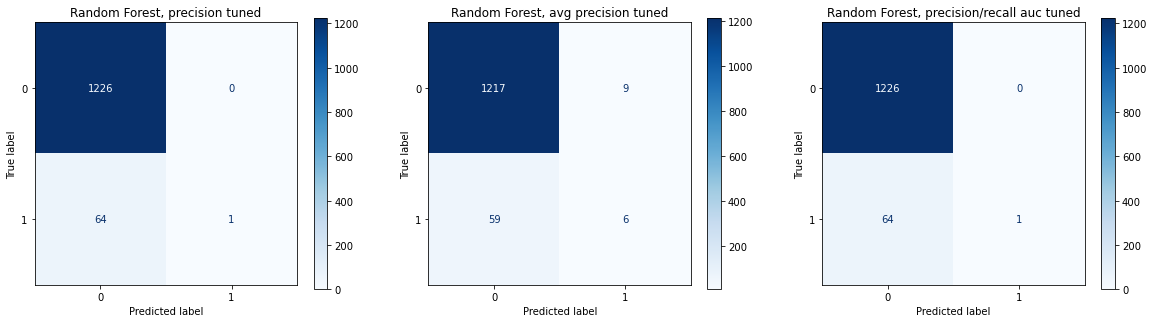

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

### FOR NORMALIZED MATRIXES
#cm1 = confusion_matrix(y_test, lr_pre_pred, normalize='true')
#cm2 = confusion_matrix(y_test, lr_avg_pre_pred, normalize='true')
#cm3 = confusion_matrix(y_test, lr_pr_auc_pred, normalize='true')

cm1 = confusion_matrix(y_test, rf_pre_pred)
cm2 = confusion_matrix(y_test, rf_avg_pre_pred)
cm3 = confusion_matrix(y_test, rf_pr_auc_pred)

cm1_dis = ConfusionMatrixDisplay(cm1).plot(ax=ax1, cmap=plt.cm.Blues)
cm2_dis = ConfusionMatrixDisplay(cm2).plot(ax=ax2, cmap=plt.cm.Blues)
cm3_dis = ConfusionMatrixDisplay(cm3).plot(ax=ax3, cmap=plt.cm.Blues)

ax1.set_title('Random Forest, precision tuned')
ax2.set_title('Random Forest, avg precision tuned')
ax3.set_title('Random Forest, precision/recall auc tuned')

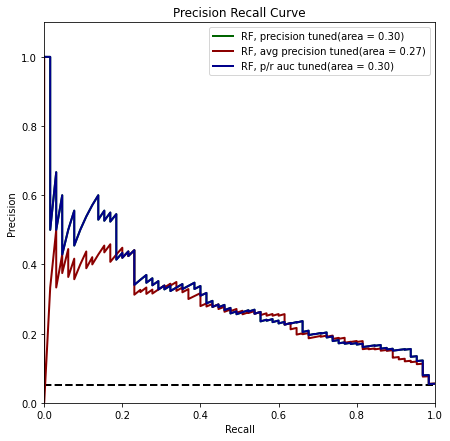

In [66]:
fig = plt.figure(figsize=(7,7))
lw = 2
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill,no_skill], color='black', lw=lw, linestyle='--')

precision, recall, _ = precision_recall_curve(y_test, rf_pre_proba)
auc_ = auc(recall, precision)
plt.plot(recall, precision, color='darkgreen', lw=lw, label='RF, precision tuned(area = %0.2f)' % auc_)

precision, recall, _ = precision_recall_curve(y_test, rf_avg_pre_proba)
auc_ = auc(recall, precision)
plt.plot(recall, precision, color='darkred', lw=lw, label='RF, avg precision tuned(area = %0.2f)' % auc_)

precision, recall, _ = precision_recall_curve(y_test, rf_pr_auc_proba)
auc_ = auc(recall, precision)
plt.plot(recall, precision, color='darkblue', lw=lw, label='RF, p/r auc tuned(area = %0.2f)' % auc_)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc="upper right")
plt.show()

## Goal is see if there is a group that is getting loans that should not be, precision is the proper measure